# LSTM multivariado

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation
from tensorflow import keras
import tensorflow as tf

In [ ]:
df = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_train_2015.csv', index_col=0, parse_dates=True)
df = df.asfreq('h')

In [ ]:
df = df.between_time('08:00:00','17:00:00')
df.head()

,SRGLOAVG1H,TAMAX1H,TAMIN1H,RHMAX1H,RHMIN1H,PRSUM1H,PAAVG1H,PAMAX1H,PAMIN1H,WS1HA,WS1HX,WD1HA
Local_Time,,,,,,,,,,,,
2015-01-01 08:00:00,107.0,12.2,9.5,96.0,89.0,0.0,743.5,743.7,743.1,2.5,4.6,42
2015-01-01 09:00:00,394.0,15.1,12.2,89.0,76.0,0.0,743.8,743.9,743.7,3.3,5.8,59
2015-01-01 10:00:00,728.0,18.1,15.1,79.0,57.0,0.0,743.7,743.9,743.4,4.4,8.4,40
2015-01-01 11:00:00,428.0,18.4,16.7,66.0,58.0,0.0,743.2,743.4,742.8,4.0,8.1,35
2015-01-01 12:00:00,403.0,18.5,17.2,65.0,55.0,0.0,742.6,742.9,742.3,3.5,7.6,34


In [ ]:
df = df[['SRGLOAVG1H','TAMAX1H', 'TAMIN1H', 'RHMIN1H','RHMAX1H']]

In [ ]:
df.head()

,SRGLOAVG1H,TAMAX1H,TAMIN1H,RHMIN1H,RHMAX1H
Local_Time,,,,,
2015-01-01 08:00:00,107.0,12.2,9.5,89.0,96.0
2015-01-01 09:00:00,394.0,15.1,12.2,76.0,89.0
2015-01-01 10:00:00,728.0,18.1,15.1,57.0,79.0
2015-01-01 11:00:00,428.0,18.4,16.7,58.0,66.0
2015-01-01 12:00:00,403.0,18.5,17.2,55.0,65.0


In [ ]:
corr_matrix = df.corr()

In [ ]:
corr_matrix['SRGLOAVG1H'].sort_values(ascending=False)

SRGLOAVG1H    1.000000
TAMAX1H       0.646968
TAMIN1H       0.538800
RHMAX1H      -0.445617
RHMIN1H      -0.583511
Name: SRGLOAVG1H, dtype: float64

In [ ]:
df_test = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_test_2015.csv', index_col=0, parse_dates=True)
df_test = df_test.asfreq('h')

In [ ]:
df_test = df_test[['SRGLOAVG1H','TAMAX1H', 'TAMIN1H', 'RHMIN1H','RHMAX1H']]

In [ ]:
df_test = df_test.between_time('08:00:00','17:00:00')

In [ ]:
df_test.head()

,SRGLOAVG1H,TAMAX1H,TAMIN1H,RHMIN1H,RHMAX1H
Local_Time,,,,,
2016-08-08 08:00:00,136.0,12.2,10.8,89.0,95.0
2016-08-08 09:00:00,337.0,15.2,12.3,73.0,90.0
2016-08-08 10:00:00,303.0,15.1,13.6,70.0,81.0
2016-08-08 11:00:00,549.0,16.5,13.3,71.0,88.0
2016-08-08 12:00:00,577.0,17.6,15.8,65.0,77.0


## Variables exógenas como entrada

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(df)

MinMaxScaler()

In [ ]:
scaled_train = scaler.transform(df)
scaled_test = scaler.transform(df_test)

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
n_input = 22 # horas hacia atrás
n_output = 1 # horas predichas
n_features = 3 # variables de entrada
generator = TimeseriesGenerator(scaled_train[:,1:], scaled_train[:,0], length=n_input, batch_size=n_output)

In [ ]:
X,y = generator[0]

In [ ]:
X

array([[[0.38974359, 0.41809291, 0.86419753, 0.94285714],
        [0.53846154, 0.55012225, 0.7037037 , 0.84285714],
        [0.69230769, 0.69193154, 0.4691358 , 0.7       ],
        [0.70769231, 0.77017115, 0.48148148, 0.51428571],
        [0.71282051, 0.79462103, 0.44444444, 0.5       ],
        [0.79487179, 0.84352078, 0.34567901, 0.44285714],
        [0.77435897, 0.85330073, 0.37037037, 0.38571429],
        [0.82564103, 0.85819071, 0.35802469, 0.4       ],
        [0.82051282, 0.71149144, 0.38271605, 0.81428571],
        [0.55897436, 0.63814181, 0.82716049, 0.92857143],
        [0.43589744, 0.49144254, 0.75308642, 0.85714286],
        [0.47179487, 0.59413203, 0.64197531, 0.74285714],
        [0.54358974, 0.62836186, 0.55555556, 0.61428571],
        [0.61538462, 0.68704156, 0.41975309, 0.51428571],
        [0.69230769, 0.75550122, 0.38271605, 0.38571429],
        [0.67179487, 0.74572127, 0.41975309, 0.44285714],
        [0.63076923, 0.74572127, 0.4691358 , 0.47142857],
        [0.625

In [ ]:
y

array([0.24357912])

In [ ]:
X.shape

(1, 22, 4)

In [ ]:
X_train = []

In [ ]:
y_train = []

In [ ]:
generator[0][1]

array([0.31837074, 0.48212801, 0.24438903, 0.10141313, 0.06899418,
       0.08645054])

In [ ]:
for batch in generator:
  if(len(batch[1])==6):
    X_train.append(batch[0][0])
    y_train.append(batch[1])


Se encuentran los datos de las variables seis horas antes y la radiación solar de las seis horas siguientes.

In [ ]:
X_train = np.array(X_train)

In [ ]:
X_train.shape

(485, 6, 3)

In [ ]:
y_train = np.array(y_train)

In [ ]:
y_train.shape

(485, 6)

## Creación del modelo

In [ ]:
# define model
model = Sequential()
model.add(LSTM(75, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 75)                23700     
                                                                 
 dense (Dense)               (None, 1)                 76        
                                                                 
Total params: 23,776
Trainable params: 23,776
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
model.fit(generator,epochs=7,verbose=True,batch_size=100)

Epoch 1/7
5828/5828 [==============================] - 55s 9ms/step - loss: 0.0284
Epoch 2/7
5828/5828 [==============================] - 53s 9ms/step - loss: 0.0213
Epoch 3/7
5828/5828 [==============================] - 51s 9ms/step - loss: 0.0200
Epoch 4/7
5828/5828 [==============================] - 50s 9ms/step - loss: 0.0191
Epoch 5/7
5828/5828 [==============================] - 49s 8ms/step - loss: 0.0186
Epoch 6/7
5828/5828 [==============================] - 49s 8ms/step - loss: 0.0184
Epoch 7/7
5828/5828 [==============================] - 49s 8ms/step - loss: 0.0182


In [ ]:
model.fit(generator,epochs=1,verbose=True,batch_size=100)

5828/5828 [==============================] - 48s 8ms/step - loss: 0.0179


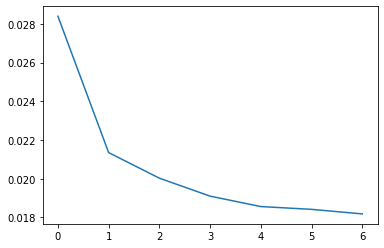

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
X_train[0].shape

IndexError: ignored

Datos de las últimas seis horas de entrenamiento

In [ ]:
eval = scaled_train[-n_input:,1:].reshape(1,n_input,3)

In [ ]:
predictions = model.predict(eval)[0]

In [ ]:
predictions

array([0.06453495], dtype=float32)

In [ ]:
scaled_test[0][0]

0.10439105219552608

In [ ]:
# create empty table 
test_predictions =  np.zeros(shape=(len(predictions), 1+n_features) )

In [ ]:
test_predictions.shape

(1, 4)

In [ ]:
test_predictions[:,0] = predictions

In [ ]:
test_predictions[0]

array([0.06453495, 0.        , 0.        , 0.        ])

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
true_predictions[:,0]

array([87.89369036])

In [ ]:
df_test['SRGLOAVG1H'][0]

136.0

### Evaluar el modelo

In [ ]:
scaled_test[0]

array([0.10439105, 0.38974359, 0.48166259, 0.86419753])

In [ ]:
scaled_test[0:n_input,1:].reshape(1,n_input,3)

array([[[0.38974359, 0.48166259, 0.86419753],
        [0.54358974, 0.55501222, 0.66666667],
        [0.53846154, 0.61858191, 0.62962963],
        [0.61025641, 0.60391198, 0.64197531],
        [0.66666667, 0.72616137, 0.56790123],
        [0.61538462, 0.69193154, 0.56790123],
        [0.61538462, 0.68215159, 0.58024691],
        [0.7025641 , 0.73594132, 0.4691358 ],
        [0.68205128, 0.69193154, 0.49382716],
        [0.55384615, 0.65770171, 0.60493827],
        [0.38461538, 0.40342298, 0.80246914],
        [0.49230769, 0.54523227, 0.7037037 ],
        [0.54358974, 0.64792176, 0.59259259],
        [0.6       , 0.67726161, 0.56790123],
        [0.62051282, 0.72127139, 0.48148148],
        [0.63589744, 0.73105134, 0.4691358 ],
        [0.73333333, 0.74572127, 0.41975309],
        [0.75384615, 0.78484108, 0.40740741],
        [0.65128205, 0.75061125, 0.51851852],
        [0.65128205, 0.70171149, 0.54320988],
        [0.38974359, 0.47188264, 0.79012346],
        [0.54358974, 0.55012225, 0

In [ ]:
predictions = []

In [ ]:
for j in range(n_input,len(df_test)):
  model_input = scaled_test[j-n_input:j,1:]
  model_input = model_input.reshape((1, n_input, n_features))
  predictions.append(model.predict(model_input)[0])

In [ ]:
predictions = np.ndarray.flatten(np.array(predictions))  
test_predictions =  np.zeros(shape=(len(predictions), 1+n_features))
test_predictions[:,0] = predictions

In [ ]:
test_predictions[:5]

array([[0.40457928, 0.        , 0.        , 0.        ],
       [0.40092912, 0.        , 0.        , 0.        ],
       [0.47423574, 0.        , 0.        , 0.        ],
       [0.47680867, 0.        , 0.        , 0.        ],
       [0.43164098, 0.        , 0.        , 0.        ]])

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
true_values = np.ndarray.flatten(df_test.iloc[n_input:]['SRGLOAVG1H'].values)

In [ ]:
true_predictions

array([[498.32719314,   4.6       ,   0.95      ,  19.        ],
       [493.92145166,   4.6       ,   0.95      ,  19.        ],
       [582.40254214,   4.6       ,   0.95      ,  19.        ],
       ...,
       [433.32352236,   4.6       ,   0.95      ,  19.        ],
       [159.85190135,   4.6       ,   0.95      ,  19.        ],
       [ 61.60402186,   4.6       ,   0.95      ,  19.        ]])

In [ ]:
rsg_predictions = true_predictions[:,0]

In [ ]:
errorMSE = mean_squared_error(true_values,rsg_predictions)
errorMAE = mean_absolute_error(true_values,rsg_predictions)

In [ ]:
errorRMSE = np.sqrt(errorMSE)

In [ ]:
errorRMSE

193.05997430680222

In [ ]:
errorMAE

150.9648603735147

## Variables exógenas y radiación solar como entrada

In [ ]:
n_input = 22 # horas hacia atrás, features
n_output = 1 # horas predichas
n_features = 3 # variables de entrada
generator = TimeseriesGenerator(scaled_train, scaled_train[:,0], length=n_input, batch_size=n_output)

In [ ]:
X_train = []
y_train = []

In [ ]:
for batch in generator:
  if(len(batch[1])==n_output):
    X_train.append(batch[0][0])
    y_train.append(batch[1])

In [ ]:
scaled_train[0]

array([0.07730673, 0.40860215, 0.26966292, 0.94285714])

In [ ]:
X_train[0]

array([[0.07730673, 0.40860215, 0.26966292, 0.94285714],
       [0.31587697, 0.56451613, 0.35955056, 0.84285714],
       [0.59351621, 0.72580645, 0.48314607, 0.7       ],
       [0.34413965, 0.74193548, 0.43820225, 0.51428571],
       [0.32335827, 0.74731183, 0.38202247, 0.5       ],
       [0.57772236, 0.83333333, 0.30337079, 0.44285714]])

In [ ]:
scaled_train[6:12,0]

array([0.31837074, 0.48212801, 0.24438903, 0.10141313, 0.06899418,
       0.08645054])

In [ ]:
y_train[0]

array([0.31837074, 0.48212801, 0.24438903, 0.10141313, 0.06899418,
       0.08645054])

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
# define model
model = Sequential()
model.add(LSTM(75, activation='relu', input_shape=(n_input, n_features+1)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 75)                24000     
                                                                 
 dense_1 (Dense)             (None, 1)                 76        
                                                                 
Total params: 24,076
Trainable params: 24,076
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(generator,epochs=7,verbose=True,batch_size=100)
#model.fit(X_train,y_train,epochs=12)

Epoch 1/7
5828/5828 [==============================] - 49s 8ms/step - loss: 0.0197
Epoch 2/7
5828/5828 [==============================] - 48s 8ms/step - loss: 0.0161
Epoch 3/7
5828/5828 [==============================] - 48s 8ms/step - loss: 0.0155
Epoch 4/7
5828/5828 [==============================] - 47s 8ms/step - loss: 0.0152
Epoch 5/7
5828/5828 [==============================] - 48s 8ms/step - loss: 0.0149
Epoch 6/7
5828/5828 [==============================] - 48s 8ms/step - loss: 0.0148
Epoch 7/7
5828/5828 [==============================] - 48s 8ms/step - loss: 0.0147


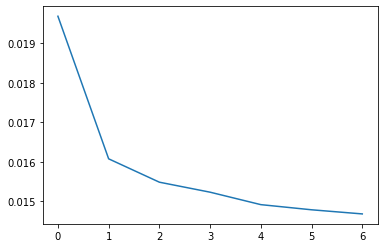

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
eval = scaled_train[-n_input:,:].reshape(1,n_input,4)

In [ ]:
eval

array([[[0.35625518, 0.72307692, 0.77506112, 0.40740741],
        [0.1963546 , 0.68205128, 0.74572127, 0.41975309],
        [0.16901408, 0.39487179, 0.43276284, 0.71604938],
        [0.22700911, 0.51282051, 0.53056235, 0.60493827],
        [0.5956918 , 0.65641026, 0.66748166, 0.4691358 ],
        [0.76304888, 0.73333333, 0.78484108, 0.41975309],
        [0.81524441, 0.82051282, 0.82885086, 0.40740741],
        [0.45153273, 0.80512821, 0.85819071, 0.34567901],
        [0.37862469, 0.80512821, 0.87775061, 0.32098765],
        [0.51449876, 0.80512821, 0.86797066, 0.28395062],
        [0.35211268, 0.80512821, 0.87775061, 0.28395062],
        [0.14001657, 0.74358974, 0.79462103, 0.34567901],
        [0.06130903, 0.41538462, 0.53545232, 0.81481481],
        [0.11019056, 0.46666667, 0.56968215, 0.7654321 ],
        [0.21789561, 0.56923077, 0.62347188, 0.67901235],
        [0.46478873, 0.63589744, 0.68704156, 0.64197531],
        [0.49047225, 0.67692308, 0.72616137, 0.5308642 ],
        [0.298

In [ ]:
predictions = model.predict(eval)[0]
predictions

array([0.07663663], dtype=float32)

In [ ]:
test_predictions =  np.zeros(shape=(len(predictions), 1+n_features) )

In [ ]:
test_predictions[:,0] = predictions

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
true_predictions[:,0]

array([102.50040917])

In [ ]:
df_test['SRGLOAVG1H'][:6]

Local_Time
2016-08-08 08:00:00    136.0
2016-08-08 09:00:00    337.0
2016-08-08 10:00:00    303.0
2016-08-08 11:00:00    549.0
2016-08-08 12:00:00    577.0
2016-08-08 13:00:00    334.0
Name: SRGLOAVG1H, dtype: float64

In [ ]:
predictions=[]

In [ ]:
for j in range(n_input,len(df_test)):
  model_input = scaled_test[j-n_input:j]
  model_input = model_input.reshape((1, n_input, n_features+1))
  predictions.append(model.predict(model_input)[0])

In [ ]:
predictions = np.ndarray.flatten(np.array(predictions))  
test_predictions =  np.zeros(shape=(len(predictions), 1+n_features))
test_predictions[:,0] = predictions

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
true_values = np.ndarray.flatten(df_test.iloc[n_input:]['SRGLOAVG1H'].values)

In [ ]:
rsg_predictions = true_predictions[:,0]


In [ ]:
errorMSE = mean_squared_error(true_values,rsg_predictions)
errorMAE = mean_absolute_error(true_values,rsg_predictions)

In [ ]:
errorMAE

132.43248900529696

## Probando con distintos grupos de variables

In [ ]:
variables = [1,3,4]

In [ ]:
df.columns[0:1]

Index(['SRGLOAVG1H'], dtype='object')

In [ ]:
for num_variables in variables:
  n_input = 22 # horas hacia atrás, features
  n_output = 1 # horas predichas
  n_features = num_variables # variables de entrada
  print('Variables',n_features)
  generator = TimeseriesGenerator(scaled_train[:,:1+num_variables], scaled_train[:,0], length=n_input, batch_size=n_output)
  # define model
  model = Sequential()
  model.add(LSTM(75, activation='relu', input_shape=(n_input, n_features+1)))
  model.add(Dense(n_output))
  model.compile(optimizer='adam', loss='mse')
  model.fit(generator,epochs=7,verbose=False,batch_size=100)
  predictions = []
  for j in range(n_input,len(df_test)):
    model_input = scaled_test[j-n_input:j,:1+num_variables]
    model_input = model_input.reshape((1, n_input, n_features+1))
    predictions.append(model.predict(model_input)[0])
  predictions = np.ndarray.flatten(np.array(predictions))  
  test_predictions =  np.zeros(shape=(len(predictions), 5))
  test_predictions[:,0] = predictions
  true_predictions = scaler.inverse_transform(test_predictions)
  true_values = np.ndarray.flatten(df_test.iloc[n_input:]['SRGLOAVG1H'].values)
  rsg_predictions = true_predictions[:,0]
  errorMSE = mean_squared_error(true_values,rsg_predictions)
  errorMAE = mean_absolute_error(true_values,rsg_predictions)
  print('MAE',errorMAE)
  print('MSE',errorMSE)

Variables 4
MAE 119.75558007328728
MSE 23903.09160235717


In [ ]:
np.sqrt(errorMSE)

154.60624697067442

Usar 4 variables obtuvo el error más pequeño hasta ahora, se utilizarán 4 para la optimización de hiperparámetros.

In [ ]:
model.save('./drive/MyDrive/DatosInvestigacion/model_LSTM_multi.h5')

## Grid search

In [ ]:
def create_Model(n_input, LSTM_neurons = 100, layers=3,n_features=0):
  # define model
  model = Sequential()
  if(layers>1):
    model.add(LSTM(LSTM_neurons, activation='relu', input_shape=(n_input, n_features+1),return_sequences=True))
    for i in range(layers-2):
        model.add(LSTM(LSTM_neurons, activation='relu',return_sequences=True))
    model.add(LSTM(LSTM_neurons, activation='relu'))
  else:
    model.add(LSTM(LSTM_neurons, activation='relu', input_shape=(n_input, n_features+1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
model = create_Model(22)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 22, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 22, 100)           80400     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
resultados=[]

In [ ]:
resultados_anteriores = []

In [ ]:
import json

In [ ]:
with open("/content/resultados.txt",'r') as fp:
    for line in fp:
      resultados_anteriores.append(json.loads(line))

In [ ]:
df_resultados_anteriores = pd.DataFrame(resultados_anteriores)

In [ ]:
combinaciones_anteriores = []

In [ ]:
df_resultados = pd.read_csv('./drive/MyDrive/DatosInvestigacion/lstm_multivariado_resultados.csv')

In [ ]:
df_resultados = pd.concat([df_resultados,df_resultados_anteriores],ignore_index=True)

In [ ]:
df_resultados

,Retrasos,Neuronas LSTM,LSTM Layers,Batch size,MSE,MAE
0,18,50,1,50,24646.745624,121.936820
1,18,50,2,50,28719.220335,130.283618
2,18,50,3,50,25159.944969,122.537291
3,18,50,1,100,25169.437996,122.810510
4,18,50,2,100,26289.117672,124.375672
...,...,...,...,...,...,...
75,22,100,1,100,24644.768356,121.234664
76,22,100,2,100,24759.182784,120.936534
77,22,100,3,100,27819.868066,128.813238
78,22,100,1,150,26112.238742,124.546668


In [ ]:
for i in range(len(df_resultados)):
  combinaciones_anteriores.append((int(df_resultados.iloc[i]['Retrasos']),
                                   int(df_resultados.iloc[i]['Neuronas LSTM']),
                                   int(df_resultados.iloc[i]['Batch size']),
                                   int(df_resultados.iloc[i]['LSTM Layers'])))

In [ ]:
combinaciones_anteriores[-1]

(22, 100, 150, 2)

In [ ]:
for retrasos in range(18,26,2): #hasta dos días y medio hacia el pasado
  for num_neuronas in range(50,101,25): 
    for batch_size in range(50,151,50):
      for num_layers in range(1,4): 
        if((retrasos,num_neuronas,batch_size,num_layers) in combinaciones_anteriores):
          continue
        n_input = retrasos # horas hacia atrás
        n_output = 1
        n_features = 4 # variables exógenas
        generator = TimeseriesGenerator(scaled_train, scaled_train[:,0], length=n_input, batch_size=n_output)
        model = create_Model(n_input,LSTM_neurons=num_neuronas,layers=num_layers,n_features=n_features)
        model.fit(generator,epochs=7,verbose=False,batch_size=batch_size)
        predictions = []
        for j in range(n_input,len(df_test)):
          model_input = scaled_test[j-n_input:j]
          model_input = model_input.reshape((1, n_input, n_features+1))
          predictions.append(model.predict(model_input)[0])

        predictions = np.ndarray.flatten(np.array(predictions))  
        test_predictions =  np.zeros(shape=(len(predictions), 5))
        test_predictions[:,0] = predictions
        true_predictions = scaler.inverse_transform(test_predictions)
        rsg_predictions = true_predictions[:,0]
        true_values = np.ndarray.flatten(df_test.iloc[n_input:]['SRGLOAVG1H'].values)

        errorMSE = mean_squared_error(true_values,rsg_predictions)
        errorMAE = mean_absolute_error(true_values,rsg_predictions)

        print({
            'Retrasos':retrasos,
            'Neuronas LSTM':num_neuronas,
            'Batch size':batch_size,
            'LSTM Layers': num_layers,
            'MSE':errorMSE,
            'MAE':errorMAE
        })
        resultados.append({
            'Retrasos':retrasos,
            'Neuronas LSTM':num_neuronas,
            'LSTM Layers': num_layers,
            'Batch size':batch_size,
            'MSE':errorMSE,
            'MAE':errorMAE
        })

{'Retrasos': 22, 'Neuronas LSTM': 100, 'Batch size': 150, 'LSTM Layers': 3, 'MSE': 27448.48566061968, 'MAE': 127.66419265624938}
{'Retrasos': 24, 'Neuronas LSTM': 50, 'Batch size': 50, 'LSTM Layers': 1, 'MSE': 29406.767794088868, 'MAE': 134.189209672708}
{'Retrasos': 24, 'Neuronas LSTM': 50, 'Batch size': 50, 'LSTM Layers': 2, 'MSE': 28433.327269733076, 'MAE': 128.90860443068848}
{'Retrasos': 24, 'Neuronas LSTM': 50, 'Batch size': 50, 'LSTM Layers': 3, 'MSE': 27089.035656050346, 'MAE': 126.98263806828965}
{'Retrasos': 24, 'Neuronas LSTM': 50, 'Batch size': 100, 'LSTM Layers': 1, 'MSE': 26105.0271453611, 'MAE': 126.91963496885695}
{'Retrasos': 24, 'Neuronas LSTM': 50, 'Batch size': 100, 'LSTM Layers': 2, 'MSE': 24762.416154718077, 'MAE': 121.01317618526829}
{'Retrasos': 24, 'Neuronas LSTM': 50, 'Batch size': 100, 'LSTM Layers': 3, 'MSE': 24697.2968346162, 'MAE': 121.06416238928448}
{'Retrasos': 24, 'Neuronas LSTM': 50, 'Batch size': 150, 'LSTM Layers': 1, 'MSE': 28665.541117045923, 'MAE

In [ ]:
resultados[0]

{'Batch size': 150,
 'LSTM Layers': 3,
 'MAE': 127.66419265624938,
 'MSE': 27448.48566061968,
 'Neuronas LSTM': 100,
 'Retrasos': 22}

In [ ]:
df_resultados_actuales = pd.DataFrame(resultados)

In [ ]:
df_resultados_actuales

,Retrasos,Neuronas LSTM,LSTM Layers,Batch size,MSE,MAE
0,22,100,3,150,27448.485661,127.664193
1,24,50,1,50,29406.767794,134.189210
2,24,50,2,50,28433.327270,128.908604
3,24,50,3,50,27089.035656,126.982638
4,24,50,1,100,26105.027145,126.919635
5,24,50,2,100,24762.416155,121.013176
6,24,50,3,100,24697.296835,121.064162
7,24,50,1,150,28665.541117,129.791525
8,24,50,2,150,29615.846950,132.391590
9,24,50,3,150,24747.374915,122.211768


In [ ]:
df_resultados = pd.concat([df_resultados,df_resultados_actuales],ignore_index=True)

In [ ]:
df_resultados

,Retrasos,Neuronas LSTM,LSTM Layers,Batch size,MSE,MAE
0,18,50,1,50,24646.745624,121.936820
1,18,50,2,50,28719.220335,130.283618
2,18,50,3,50,25159.944969,122.537291
3,18,50,1,100,25169.437996,122.810510
4,18,50,2,100,26289.117672,124.375672
...,...,...,...,...,...,...
103,24,100,2,100,24081.068026,119.449035
104,24,100,3,100,25669.856754,124.085645
105,24,100,1,150,27161.019932,128.987377
106,24,100,2,150,24840.064499,120.295463


In [ ]:
df_resultados[df_resultados['MAE'] == df_resultados['MAE'].min()]

,Retrasos,Neuronas LSTM,LSTM Layers,Batch size,MSE,MAE
39,20,75,1,100,24078.177209,118.81519


In [ ]:
df_resultados[df_resultados['MSE'] == df_resultados['MSE'].min()]

,Retrasos,Neuronas LSTM,LSTM Layers,Batch size,MSE,MAE
99,24,100,1,50,23986.621583,119.348837


In [ ]:
df_resultados.to_csv('./drive/MyDrive/DatosInvestigacion/lstm_multivariado_resultados.csv',index=False)

In [ ]:
import seaborn as sns

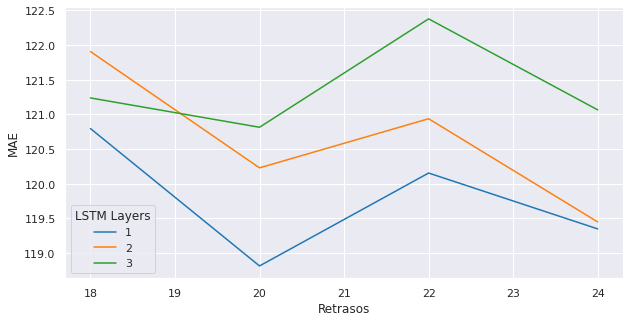

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lineplot(data=df_resultados, x='Retrasos', y='MAE',hue='LSTM Layers',palette='tab10',err_style="bars", ci=0, estimator=np.min)

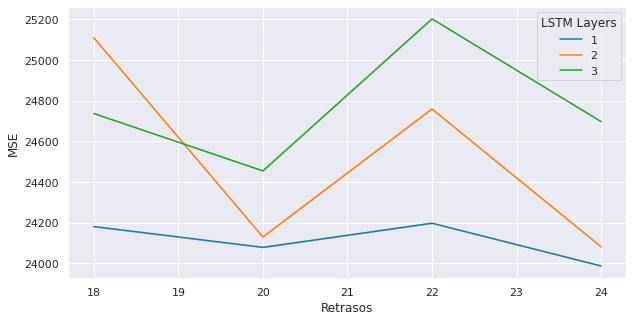

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lineplot(data=df_resultados, x='Retrasos', y='MSE',hue='LSTM Layers',palette='tab10',ci=0, estimator=np.min)

## Número de neruonas

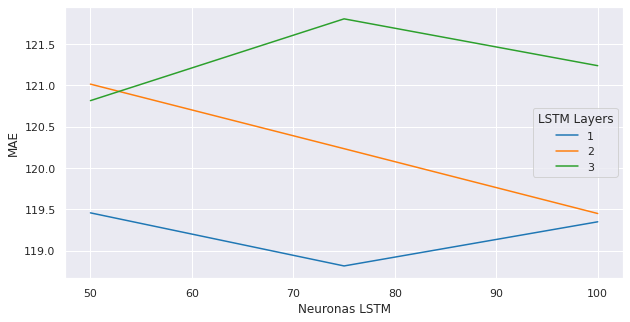

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lineplot(data=df_resultados, x='Neuronas LSTM', y='MAE',hue='LSTM Layers',palette='tab10', ci=0, estimator=np.min)

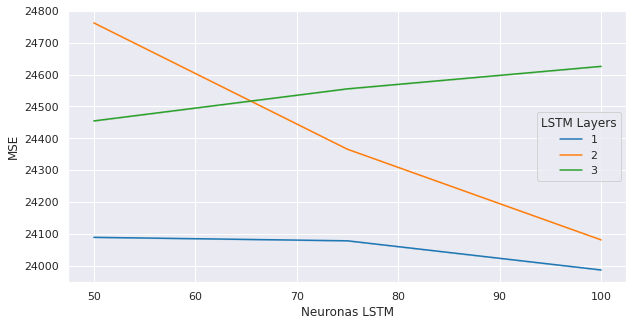

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lineplot(data=df_resultados, x='Neuronas LSTM', y='MSE',hue='LSTM Layers',palette='tab10', ci=0, estimator=np.min)

### Batch size

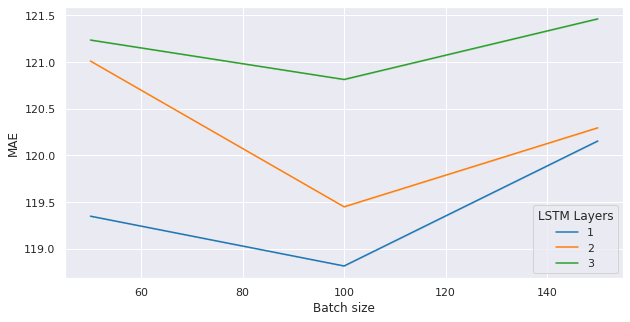

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lineplot(data=df_resultados, x='Batch size', y='MAE',hue='LSTM Layers',palette='tab10', ci=0, estimator=np.min)

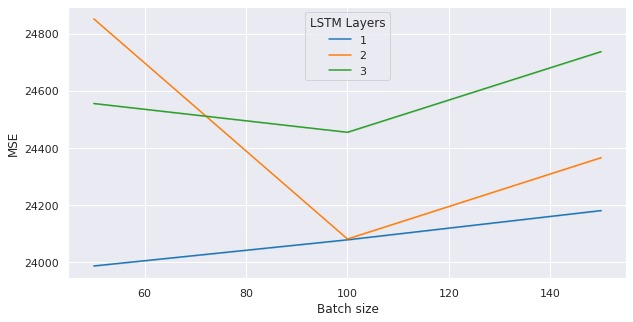

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lineplot(data=df_resultados, x='Batch size', y='MSE',hue='LSTM Layers',palette='tab10', ci=0, estimator=np.min)

## Conclusiones

* Una capa LSTM obtiene mejores resultados
* El mejor batch size se encuentra en 100
* El mejor número de neuronas LSTM se encuentra entre 75 y 100, se elegirán 75 para tener un modelo menos complejo.

## Probando el mejor modelo

In [ ]:
n_input = 20
num_layers = 1
batch_size = 100
num_neuronas = 100
n_output=1
n_features=4

In [ ]:
model = create_Model(n_input,LSTM_neurons=num_neuronas,layers=num_layers,n_features=n_features)

In [ ]:
generator = TimeseriesGenerator(scaled_train, scaled_train[:,0], length=n_input, batch_size=n_output)
model.fit(generator,epochs=7,verbose=True,batch_size=batch_size)
predictions = []
for j in range(n_input,len(df_test)):
  model_input = scaled_test[j-n_input:j]
  model_input = model_input.reshape((1, n_input, n_features+1))
  predictions.append(model.predict(model_input)[0])

predictions = np.ndarray.flatten(np.array(predictions))  
test_predictions =  np.zeros(shape=(len(predictions), 5))
test_predictions[:,0] = predictions
true_predictions = scaler.inverse_transform(test_predictions)
rsg_predictions = true_predictions[:,0]
true_values = np.ndarray.flatten(df_test.iloc[n_input:]['SRGLOAVG1H'].values)

errorMSE = mean_squared_error(true_values,rsg_predictions)
errorMAE = mean_absolute_error(true_values,rsg_predictions)

Epoch 1/7
5830/5830 [==============================] - 53s 8ms/step - loss: 0.0204
Epoch 2/7
5830/5830 [==============================] - 48s 8ms/step - loss: 0.0159
Epoch 3/7
5830/5830 [==============================] - 48s 8ms/step - loss: 0.0154
Epoch 4/7
5830/5830 [==============================] - 47s 8ms/step - loss: 0.0152
Epoch 5/7
5830/5830 [==============================] - 48s 8ms/step - loss: 0.0149
Epoch 6/7
5830/5830 [==============================] - 47s 8ms/step - loss: 0.0148
Epoch 7/7
5830/5830 [==============================] - 48s 8ms/step - loss: 0.0146


In [ ]:
errorMSE

25220.772406707383

In [ ]:
errorMAE

121.51117912750277

In [ ]:
model.save('./drive/MyDrive/DatosInvestigacion/RSG_multivariado_best_model.h5')